# 2.Image Segmentation

# 2.1 Image Segmentation with classical image processing methods (Region based segmentation)

In [1]:
from skimage.color import rgb2gray
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage
from PIL import Image
from sklearn.cluster import KMeans
from skimage.filters import sobel
import skimage
import os
import glob
import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = "E:/datasets/PlantSegDatasets/PlantSegmentationDatasets/vinecuttings/images/*.jpg"  # Path to the image files
image_paths = glob.glob(data_path)  # Getting a list of image file paths using glob

images = []  # Initializing an empty list to store the images
for image_path in image_paths:  # Iterating over each image file path
    image = Image.open(image_path)  # Opening the image using PIL
    image = image.resize((320, 225))  # Resizing the image to the desired dimensions
    image_array = np.array(image)  # Converting the image to a numpy array
    normalized_image = image_array / 255.0  # Normalizing the image by dividing by 255
    images.append(normalized_image)  # Appending the normalized image to the list of images



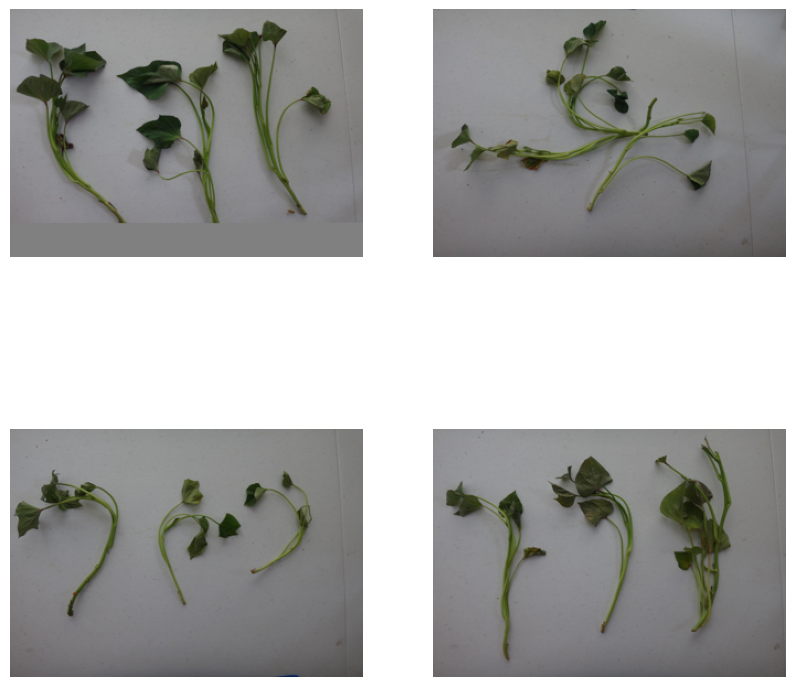

In [3]:
num_images = 4  # Number of random images to select
random_images = random.sample(images, num_images)  # Selecting random images from the list of images

# Displaying the selected random images in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(random_images[i])  # Displaying each random image
    ax.axis('off')  # Turning off axis labels
plt.show()  # Showing the plot with random images


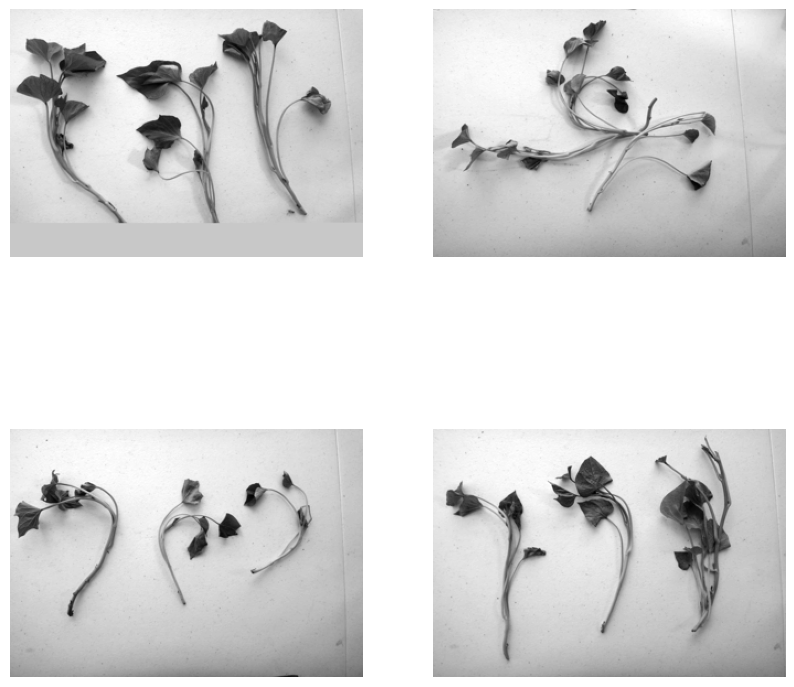

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # Creating a 2x2 grid of subplots
for i, ax in enumerate(axes.flat):
    gray = rgb2gray(random_images[i])  # Converting the random image to grayscale
    ax.imshow(gray, cmap='gray')  # Displaying the grayscale image
    ax.axis('off')  # Turning off axis labels
plt.show()  # Showing the plot with grayscale images

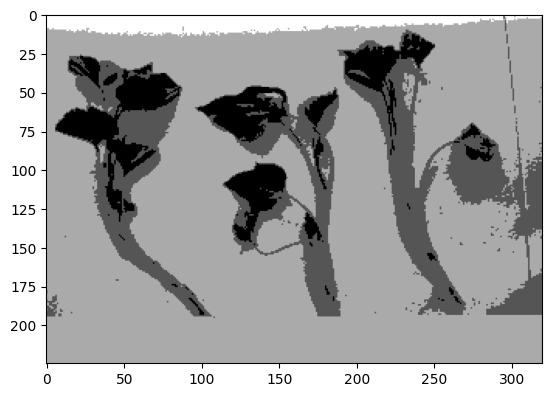

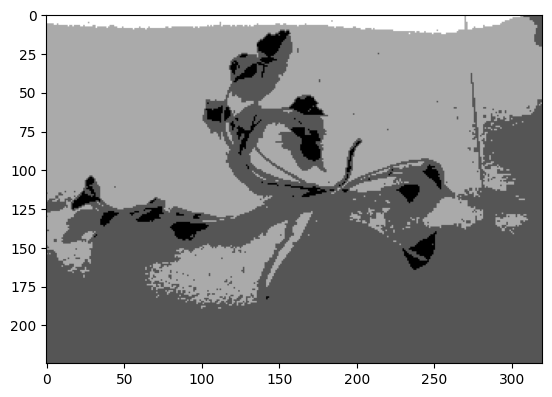

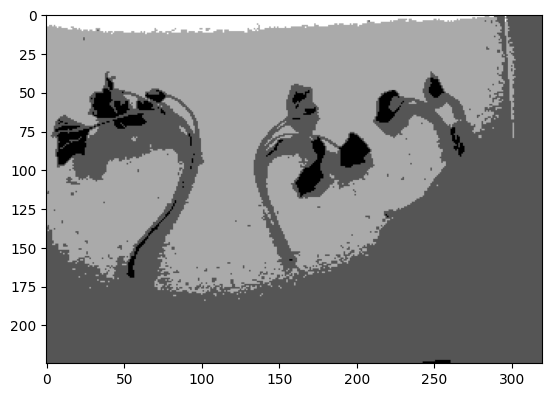

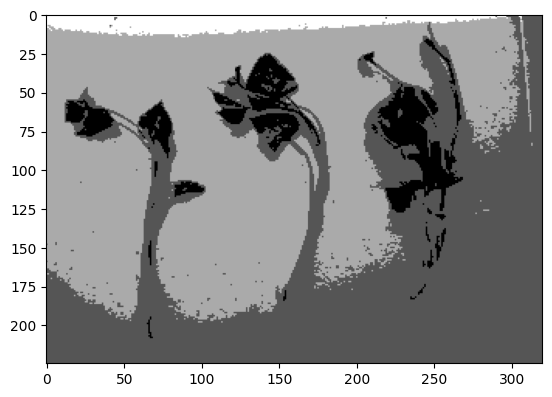

In [5]:
# Local thresholding

for image in random_images:
    gray = rgb2gray(image)
    gray_r = gray.reshape(gray.shape[0] * gray.shape[1])
    for i in range(gray_r.shape[0]):
        if gray_r[i] > gray_r.mean():
            gray_r[i] = 3
        elif gray_r[i] > 0.5:
            gray_r[i] = 2
        elif gray_r[i] > 0.25:
            gray_r[i] = 1
        else:
            gray_r[i] = 0
    gray = gray_r.reshape(gray.shape[0], gray.shape[1])
    plt.imshow(gray, cmap='gray')
    plt.show()


# 2.2 Image Segmentation Using U-Net

# 2.2.1 Import Libraries

In [6]:
import tensorflow as tf
import cv2
import os
import random
import numpy as np
import glob

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

random.seed(23)

# 2.2.2 loading Image Dataset

In [7]:
def img_resize(image, y_dim, x_dim):
    """
    Resize the input image to the specified dimensions.

    Args:
    - image (numpy.ndarray): The input image.
    - y_dim (int): The desired height of the resized image.
    - x_dim (int): The desired width of the resized image.

    Returns:
    - resized_img (numpy.ndarray or None): The resized image, or None if the input image is invalid.
    """
    if image is None or image.size == 0 or image.shape[0] == 0 or image.shape[1] == 0:
        return None
    resized_img = cv2.resize(image, (y_dim, x_dim))
    return resized_img

In [8]:
image_path = "E:/datasets/PlantSegDatasets/PlantSegmentationDatasets/vinecuttings/images/*.jpg"
mask_path = "E:/datasets/PlantSegDatasets/PlantSegmentationDatasets/vinecuttings/masks/*.png"

In [9]:
# Sort the list of image file names based on file name without extension
image_names = sorted(glob.glob(image_path), key=lambda x: x.split('.')[0])
# Sort the list of mask file names based on file name without extension
mask_names = sorted(glob.glob(mask_path), key=lambda x: x.split('.')[0])



In [10]:
train_images_array = []

# Loop through each image file
for image in image_names:
    # Read the image
    img = cv2.imread(image, -1)
    # Resize the image
    img_resized = img_resize(img, 128, 128)
    # Append the resized image to the list
    train_images_array.append(img_resized)

# Convert the list of resized images to a numpy array
train_images_array = np.array(train_images_array)


In [11]:
mask_images_array = []

# Loop through each mask file
for mask in mask_names:
    # Read the mask image
    msk = cv2.imread(mask, 0)
    # Resize the mask image
    msk_resized = img_resize(msk, 128, 128)
    # Append the resized mask image to the list
    mask_images_array.append(msk_resized)

# Convert the list of resized mask images to a numpy array
mask_images_array = np.array(mask_images_array)

In [12]:
len(train_images_array)

60

In [13]:
len(mask_images_array)

60

In [14]:
train_images_array[0].shape

(128, 128, 3)

In [15]:
mask_images_array[0].shape

(128, 128)

In [16]:
def normalize_array(arr):
    """
    Normalize the input array by dividing by 255.0.
    
    Parameters:
        arr (numpy.ndarray): Input array to be normalized.
    
    Returns:
        numpy.ndarray: Normalized array.
    """
    return arr / 255.0

# Normalize the training images array
X = normalize_array(train_images_array)

# Normalize the mask images array
y = normalize_array(mask_images_array)

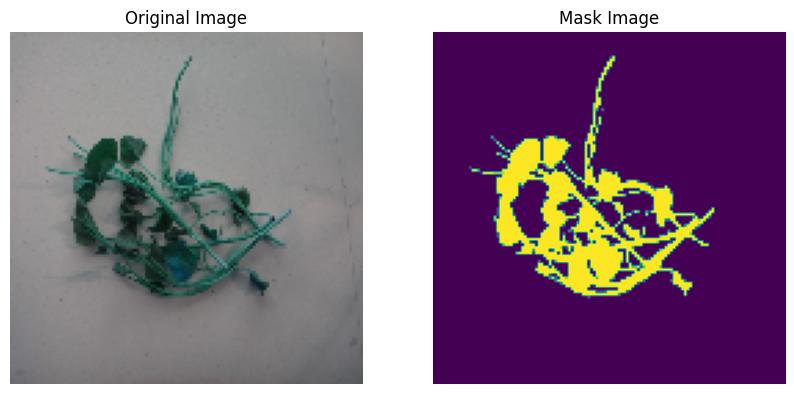

In [17]:
rand_num = random.randint(0, 49)  # Generate a random index between 0 and 49 inclusive

# Display the original image and its corresponding mask side by side
figure, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(X[rand_num])  # Display the original image
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(y[rand_num])  # Display the corresponding mask image
axes[1].set_title('Mask Image')
axes[1].axis('off')
plt.show()

In [18]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets with 20% of the data reserved for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [19]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Define a convolutional block consisting of two convolutional layers followed by optional dropout and max pooling.

    Args:
    - inputs (tensor): Input tensor to the convolutional block.
    - n_filters (int): Number of filters in the convolutional layers.
    - dropout_prob (float): Dropout probability.
    - max_pooling (bool): Whether to apply max pooling.

    Returns:
    - next_layer (tensor): Output tensor of the convolutional block.
    - skip_connection (tensor): Skip connection tensor.
    """
    conv = Conv2D(n_filters,  # Number of filters
                  3,          # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters,  # Number of filters
                  3,          # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2, 2))(conv)
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection


In [20]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Define an upsampling block which combines expansive and contractive paths.

    Args:
    - expansive_input (tensor): Input tensor from the expansive path (upsampling).
    - contractive_input (tensor): Input tensor from the contractive path.
    - n_filters (int): Number of filters in the convolutional layers.

    Returns:
    - conv (tensor): Output tensor of the upsampling block.
    """
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)

    return conv


In [21]:
def unet_model(input_size=(128, 128, 3), n_filters=32):
    """
    Define the U-Net model architecture.

    Args:
    - input_size (tuple): Input size of the model.
    - n_filters (int): Number of filters in the convolutional layers.

    Returns:
    - model (tf.keras.Model): U-Net model.
    """
    inputs = Input(input_size)

    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 2**2*n_filters)
    cblock4 = conv_block(cblock3[0], 2**3*n_filters, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    cblock5 = conv_block(cblock4[0], 2**4*n_filters, dropout_prob=0.3, max_pooling=False) 

    ublock6 = upsampling_block(cblock5[0], cblock4[1],  2**3*n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  2**2*n_filters)
    ublock8 = upsampling_block(ublock7, cblock2[1],  2*n_filters)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(1, 1, padding='same',activation='sigmoid')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model


In [22]:
model = unet_model(n_filters=32,input_size=(128,128,3))

model.compile(optimizer='adam',loss='binary_crossentropy', 
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

 conv2d_19 (Conv2D)          (None, 128, 128, 1)          33        ['conv2d_18[0][0]']           
                                                                                                  
Total params: 8639745 (32.96 MB)
Trainable params: 8639745 (32.96 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________


In [24]:
# Early stopping callback: Stops training when the model doesn't improve after 5 epochs
# Restores the weights of the best version of the model
early_stopping_cb = EarlyStopping(patience=5,restore_best_weights=True)
model_checkpoint_cb =
ModelCheckpoint("F:/tarbiat modares/ترم3/پردازش تصویر/projects/pro3/image segmentation/model.h5",save_best_only=True)

In [25]:
# Number of epochs for training
num_epochs = 50

# Fit the model to the training data
# Use early stopping callback to stop training when validation loss doesn't improve after 5 epochs
# Also, provide validation data to monitor the model's performance on the test set during training
history = model.fit(X_train, y_train, epochs=num_epochs, callbacks=[early_stopping_cb], validation_data=(X_test, y_test))


Epoch 1/50


2/2 [==============================] - 7s 2s/step - loss: 0.5831 - accuracy: 0.6903 - val_loss: 0.2841 - val_accuracy: 0.8936
Epoch 2/50
2/2 [==============================] - 3s 1s/step - loss: 0.2809 - accuracy: 0.8894 - val_loss: 0.2496 - val_accuracy: 0.8937
Epoch 3/50
2/2 [==============================] - 3s 1s/step - loss: 0.2680 - accuracy: 0.8894 - val_loss: 0.2478 - val_accuracy: 0.8937
Epoch 4/50
2/2 [==============================] - 3s 1s/step - loss: 0.2579 - accuracy: 0.8894 - val_loss: 0.2205 - val_accuracy: 0.8963
Epoch 5/50
2/2 [==============================] - 3s 1s/step - loss: 0.2315 - accuracy: 0.8925 - val_loss: 0.2095 - val_accuracy: 0.8946
Epoch 6/50
2/2 [==============================] - 3s 1s/step - loss: 0.2128 - accuracy: 0.8960 - val_loss: 0.2013 - val_accuracy: 0.9448
Epoch 7/50
2/2 [==============================] - 3s 1s/step - loss: 0.2048 - accuracy: 0.9252 - val_loss: 0.2107 - val_accuracy: 0.8958
Epoch 8/50
2/2 [=======================

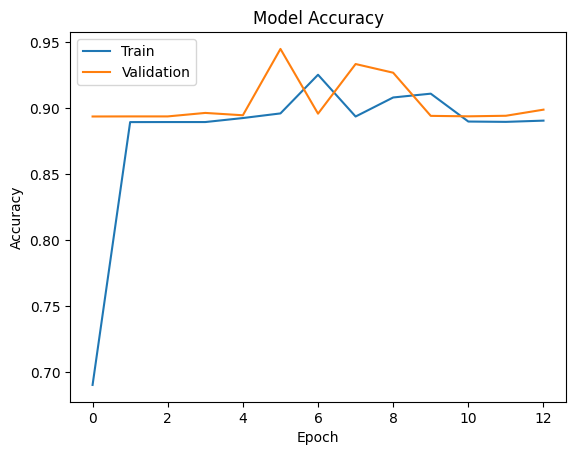

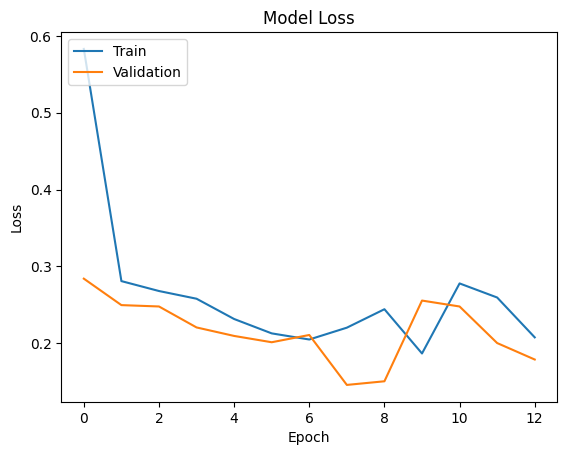

In [26]:
# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'])  # Plot training accuracy
plt.plot(history.history['val_accuracy'])  # Plot validation accuracy
plt.title('Model Accuracy')  # Set the title of the plot
plt.ylabel('Accuracy')  # Set the label for the y-axis
plt.xlabel('Epoch')  # Set the label for the x-axis
plt.legend(['Train', 'Validation'], loc='upper left')  # Add a legend indicating the data
plt.show()  # Display the plot

# Plot training and validation loss over epochs
plt.plot(history.history['loss'])  # Plot training loss
plt.plot(history.history['val_loss'])  # Plot validation loss
plt.title('Model Loss')  # Set the title of the plot
plt.ylabel('Loss')  # Set the label for the y-axis
plt.xlabel('Epoch')  # Set the label for the x-axis
plt.legend(['Train', 'Validation'], loc='upper left')  # Add a legend indicating the data
plt.show()  # Display the plot

In [27]:
print(len(X_test))

12


1/1 [==============================] - 0s 46ms/step


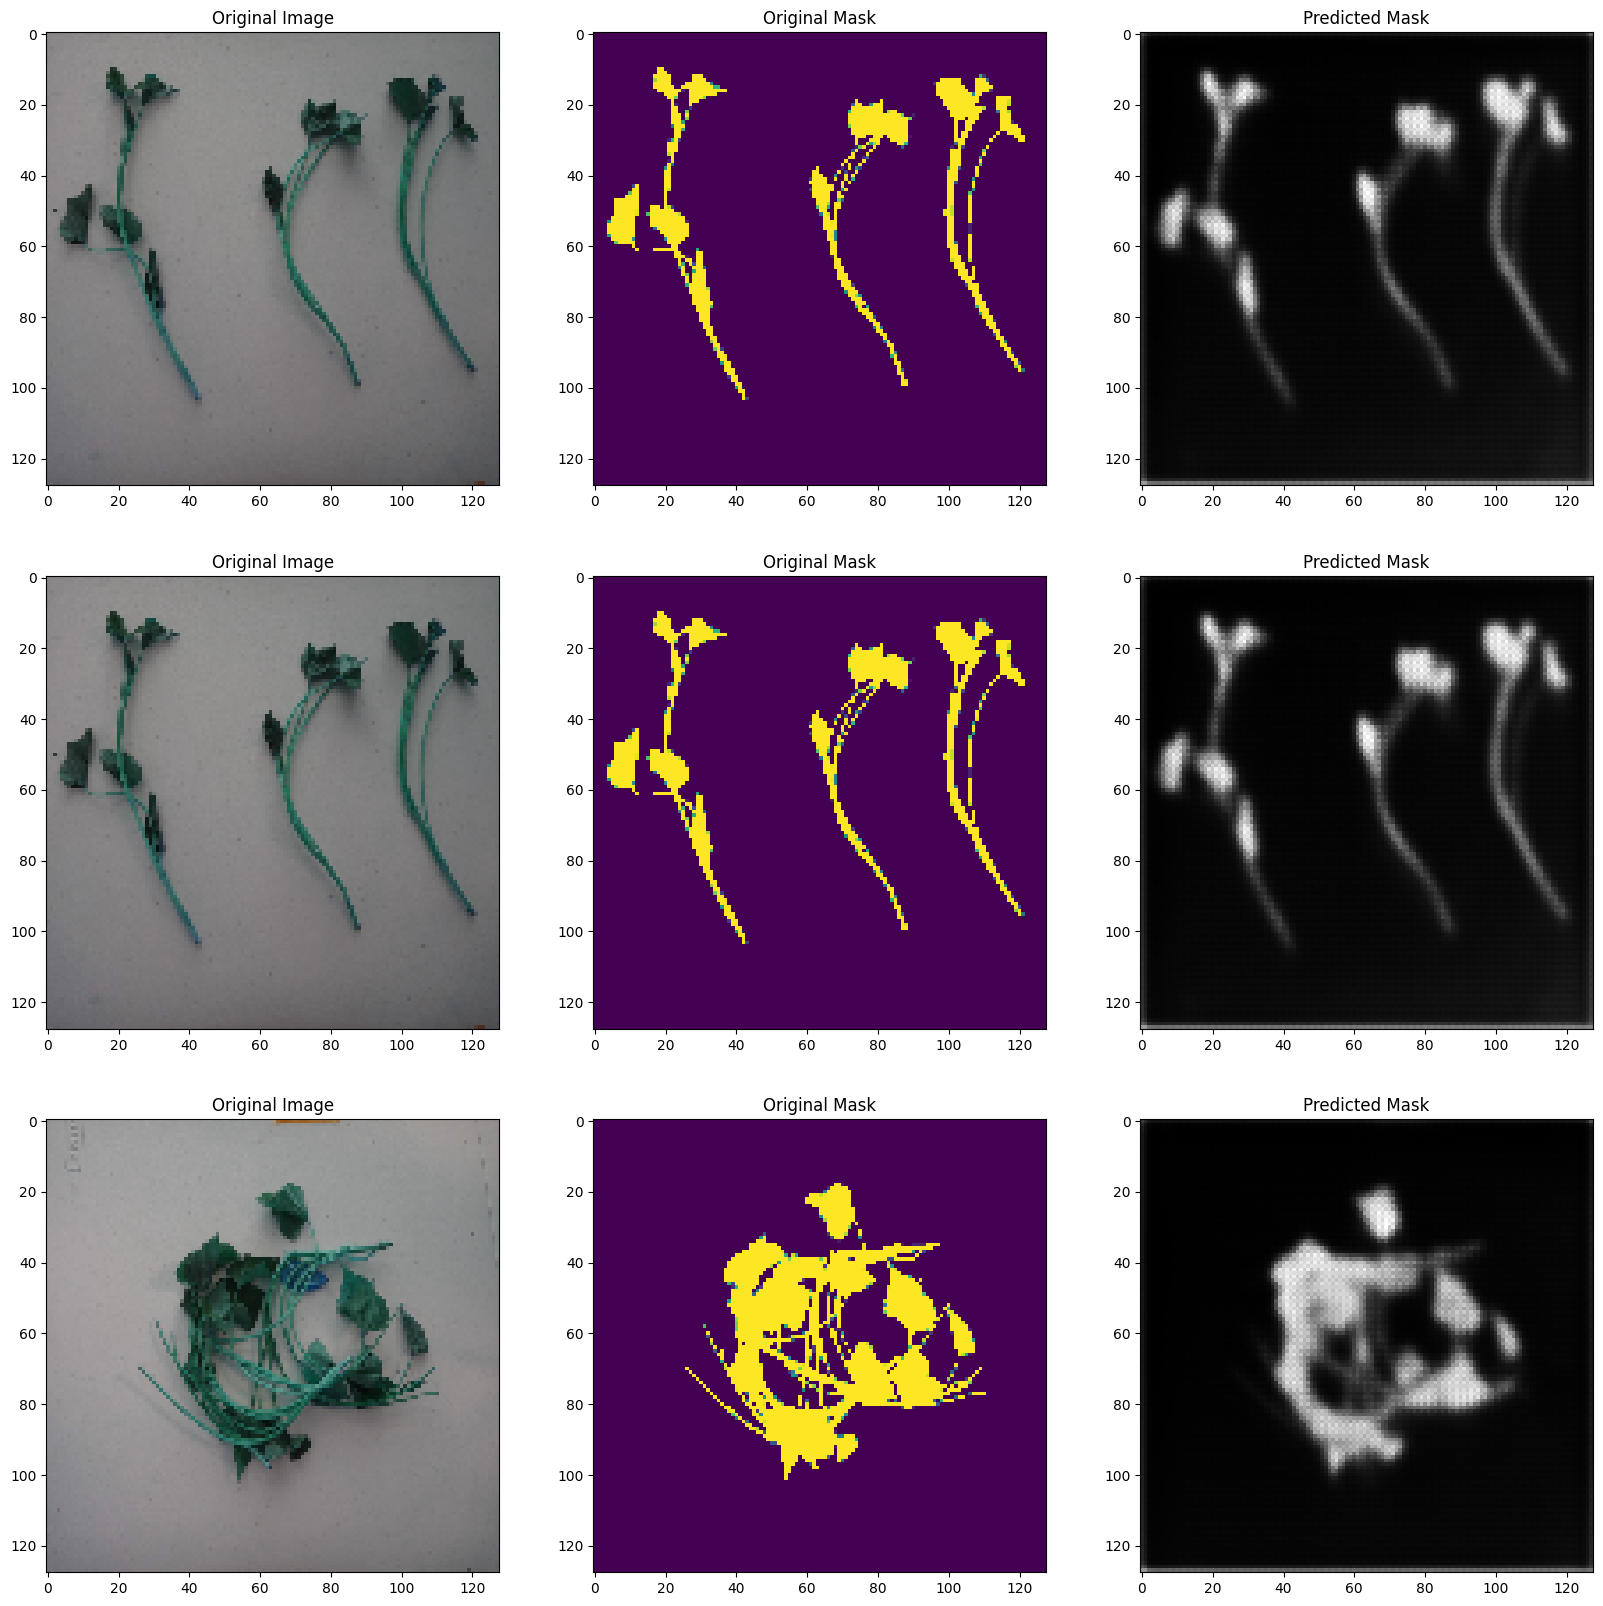

In [28]:
# Create subplots with 3 rows and 3 columns
figure, axes = plt.subplots(3, 3, figsize=(20, 20))

# Iterate over the rows
for i in range(0, 3):
    # Generate a random number between 0 and 4
    rand_num = random.randint(0, 4)
    
    # Display the original image
    original_img = X_test[rand_num]
    axes[i, 0].imshow(original_img)
    axes[i, 0].title.set_text('Original Image')
    
    # Display the original mask
    original_mask = y_test[rand_num]
    axes[i, 1].imshow(original_mask)
    axes[i, 1].title.set_text('Original Mask')
    
    # Reshape the original image and predict the mask
    original_img = np.expand_dims(original_img, axis=0)
    predicted_mask = model.predict(original_img).reshape(128, 128)
    
    # Display the predicted mask
    axes[i, 2].imshow(predicted_mask, cmap='gray')
    axes[i, 2].title.set_text('Predicted Mask')
    
plt.show()  # Display the subplots
